In [446]:
import json
import pandas as pd
import re
import requests
from pprint import pprint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
import collections
from selenium_driver import setProxy
from gc import collect
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from unidecode import unidecode

warnings.filterwarnings('ignore')
pd.set_option('max_colwidth', 300)

BASE_PATH = '/content/gdrive/My Drive/Colab Notebooks/Meli2020/Meli_Desafio_Archivos'

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

Consigna del ejercicio:
- análisis exploratorio de las publicaciones con descuento
- generar un modelo que genere prediccion de la cantidad de ventas de un articulo

Links:
- REFERENCIA DE UTILIZACION DE API PARA BUSCAR ITEMS https://developers.mercadolibre.com.ar/es_ar/items-y-busquedas
- REFERENCIA DE UTILIZACION DE API PARA CATEGORIAS https://developers.mercadolibre.com.ar/es_ar/categoriza-productos


Que parametros pueden influeciar las ventas de un producto?
- Rating del vendedor
- Titulo del articulo
- Descripcion del articulo
- Precio
- Cantidad disponible (al inicio de la publicacion)
- Condicion
- Porcentaje de descuento (mas siendo que se va a trabajar exclusivamente con articulos en descuento)
- Cuotas ?

In [79]:
#atributos para trae por articulo 

item_filter_keys = [
    'id',
    'seller_id',
    'available_quantity',
    'tags',
    'seller', # revisar
    'price',
    'original_price',
    'installments',
    'condition',
    'catalog_listing',
    'listing_type_id',
    'sale_price',
    'shipping',
    'sold_quantity',
    'tags',
    'title',
    'attributes', #count
    'catalog_product_id',
    'pictures',
    'health'
]

In [61]:
items_ls = []
categorias = ['televisor','celular','monitor','auricular','mouse','teclado','cable','accesorio','silla']
marcas = ['samsung','asus','logitech','genius','razer','steel series','apple','lg','acer']

with open('items_test.jl','a') as fi:
    for categ in categorias:
        for marca in marcas:
            for off in range(0,1050,50):
                response = requests.get('https://api.mercadolibre.com/sites/MLA/search?q={}%{}&limit=50&offset={}'.format(categ,marca,off))
                try:
                    for result in json.loads(response.text)['results']:
                        result_dict = {}
                        for fil in item_filter_keys:
                            if fil in result.keys():
                                result_dict[fil] = result[fil]
                            
                        fi.write(json.dumps(result_dict)+'\n')
                
                except Exception as e:
                    print(str(e))
                    pass
                
                time.sleep(2)

In [ ]:
json_dict = []
with open('items_test.jl','r') as fi:
    for line in fi.readlines():
        json_dict.append(json.loads(line))

In [ ]:
print('Cantidad de items obtenidos: ',len(json_dict))

count = 0
for item in json_dict:
    if item['original_price'] != None:
        count += 1
print('Cantidad de items con descuento: ',count)

<h3>No fueron muchos los productos con descuento obtenidos a traves de la API...
Plan B<\h3>

In [ ]:
driver = setProxy(headless=True)
cant_paginas = 209
with open('discount_items_links2.txt','a') as fi:
    for pag in range(1,210):
        driver.get('https://www.mercadolibre.com.ar/ofertas?page={}'.format(pag))
        for elem in driver.find_elements_by_class_name(prom_class):
            fi.write(elem.get_attribute('href')+'\n')

        
        time.sleep(2)

In [6]:
with open('discount_items_links2.txt','r') as fi:
    selenium_items_links = fi.readlines()

print(len(selenium_items_links))
print(len(set(selenium_items_links)))

10192
10192


In [14]:
selenium_parsed_links = ['MLA'+re.search(r'.*\/MLA-(\d+)-.*',x).group(1) for x in selenium_items_links]

In [23]:
with open('discount_items_api_info.jl','a') as fi:
    for item in selenium_parsed_links:
        response = requests.get('https://api.mercadolibre.com/items?ids={}'.format(item))
        fi.write(json.dumps(json.loads(response.text)[0]['body'])+'\n')

In [24]:
items_json_dict = []
with open('discount_items_api_info.jl','r') as fi:
    for line in fi.readlines():
        items_json_dict.append(json.loads(line))

In [28]:
seller_ids = [x['seller_id'] for x in items_json_dict]
print('Ids de vendedores unicos: ',len(set(seller_ids)))

Ids de vendedores unicos:  1721


In [32]:
with open('discount_items_sellers_info.jl','a') as fi:
    for seller in set(seller_ids):
        fi.write((requests.get('https://api.mercadolibre.com/users/{}'.format(seller)).text)+'\n')

<h3>Obteniendo los ratings y cantidad de reviews de un producto<\h3>

In [ ]:
clase_descripcion = 'ui-pdp-description__content'

with open('discount_items_rating_descrip.txt','a') as fi:
    fail_count = 0
    for item_link in selenium_items_links[2:]:
        driver.get(item_link)
        item_id = 'MLA'+re.search(r'.*\/MLA-(\d+)-.*',item_link).group(1)
        try:
            fail_count = 0
            rewiew_amount = (driver.find_element_by_class_name('ui-pdp-review__amount').text).split()[0]
            parent_rating = driver.find_element_by_class_name('ui-pdp-review__ratings')
            rating_stars_ls = [[x.get_attribute('class').split('-')[-1],x.get_attribute('width')] for x in parent_rating.find_elements_by_xpath("./*")]
            stars = 0
            for stars_ls in rating_stars_ls:
                if stars_ls[0] == 'full' and stars_ls[1] == '10': # Representa una estrella completa, si el segundo elemento es 11 la estrella esta vacia
                    stars += 1
                elif stars_ls[0] == 'half': # Representa una media estrella
                    stars += 0.5
                else:
                    pass
            
        except:
            stars = 0
            review_amount = '0'
            fail_count += 1
        try:
            descripcion = (driver.find_element_by_class_name(clase_descripcion).text).replace('\n',' ')
        except:
            descripcion = 'None'
        fi.write('_\t\t_'.join([item_id,str(stars),rewiew_amount,descripcion])+'\n')
        
        if fail_count >= 100:
            print('Todo mal :c')
            break
            
driver.close()

<h3> Juntando los datos </h3>

In [246]:
with open('discount_items_api_info.jl','r') as fi:
    items_api_info_dict = [json.loads(x) for x in fi.readlines()]

In [247]:
filtered_items_api = []
for item in items_api_info_dict:
    new_item = {}
    for filt in item_filter_keys:
        if filt in item.keys():
            if (filt == 'attributes') or (filt == 'pictures'):
                new_item[filt] = len(item[filt])
            else:
                new_item[filt] = item[filt]
    
    filtered_items_api.append(new_item)

In [248]:
with open('discount_items_rating_descrip.txt','r') as fi:
    selenium_items = [x.split('_\t\t_') for x in fi.readlines()]

In [249]:
with open('discount_items_sellers_info.jl','r') as fi:
    items_seller_dict = [json.loads(x) for x in fi.readlines()]

In [250]:
seller_filter_ls = [
    'id',
    'user_type',
    'tags',
    'points',
    'seller_reputation_level_id',
    'seller_reputation_power_seller_status',
    'seller_reputation_transactions_canceled',
    'seller_reputation_transactions_completed',
    'seller_reputation_transactions_ratings_negative',
    'seller_reputation_transactions_ratings_neutral',
    'seller_reputation_transactions_ratings_positive',
    'buyer_reputation_tags'
]

In [251]:
flat_items_seller_dict = [flatten(x) for x in items_seller_dict]
filtered_seller_info = []
for item in flat_items_seller_dict:
    new_item = {}
    for filt in seller_filter_ls:
        if filt in item.keys():
            new_item[filt] = item[filt]
    
    filtered_seller_info.append(new_item)

In [252]:
df_info_api = pd.DataFrame(filtered_items_api)
df_descript = pd.DataFrame(selenium_items,columns=['item_id','rating','review_count','description'])
df_sellers  = pd.DataFrame(filtered_seller_info)

In [253]:
# Limpiando un poco la memoria
del flat_items_seller_dict, items_seller_dict, selenium_items, filtered_items_api, items_api_info_dict
collect()

1379396

In [254]:
# Revisando columnas con mismo nombre
print([x for x in df_descript.columns if x in df_info_api.columns])
print([x for x in df_descript.columns if x in df_sellers.columns])
print([x for x in df_info_api.columns if x in df_sellers.columns])

[]
[]
['id', 'tags']


In [255]:
df_sellers.rename(columns={'tags':'seller_tags','id':'seller_id'},inplace=True)
df_info_api.rename(columns={'id':'item_id'},inplace=True)

In [256]:
df_main = pd.merge(df_info_api,df_descript,on='item_id')
df_main = pd.merge(df_main,df_sellers,on='seller_id')

In [257]:
df_main = df_main[df_main['original_price'].notnull()]
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10492 entries, 0 to 10671
Data columns (total 30 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   item_id                                          10492 non-null  object 
 1   seller_id                                        10492 non-null  int64  
 2   available_quantity                               10492 non-null  int64  
 3   tags                                             10492 non-null  object 
 4   price                                            10492 non-null  float64
 5   original_price                                   10492 non-null  float64
 6   condition                                        10492 non-null  object 
 7   catalog_listing                                  10492 non-null  bool   
 8   listing_type_id                                  10492 non-null  object 
 9   shipping                    

<h3> Normalizcion de los datos <\h3>

In [258]:
df_main['rating'] = df_main['rating'].astype('float')
df_main['review_count'] = df_main['review_count'].astype('int')
df_main['catalog_listing'] = df_main['catalog_listing'].astype('int')

In [259]:
df_main['item_id'].nunique()

9909

In [260]:
df_main = df_main.drop_duplicates(['item_id'])
df_main['item_id'].count()

9909

In [261]:
df_main.columns

Index(['item_id', 'seller_id', 'available_quantity', 'tags', 'price',
       'original_price', 'condition', 'catalog_listing', 'listing_type_id',
       'shipping', 'sold_quantity', 'title', 'attributes',
       'catalog_product_id', 'pictures', 'health', 'rating', 'review_count',
       'description', 'user_type', 'seller_tags', 'points',
       'seller_reputation_level_id', 'seller_reputation_power_seller_status',
       'seller_reputation_transactions_canceled',
       'seller_reputation_transactions_completed',
       'seller_reputation_transactions_ratings_negative',
       'seller_reputation_transactions_ratings_neutral',
       'seller_reputation_transactions_ratings_positive',
       'buyer_reputation_tags'],
      dtype='object')

In [263]:
map_power_status = {None:0,"silver" : 1, "gold": 2, "platinum": 3}
df_main['seller_reputation_power_seller_status'] = df_main['seller_reputation_power_seller_status'].map(map_power_status)

In [264]:
shipping_ls = [a for x in list(df_main['shipping']) for a in x]
print(set(shipping_ls))

{'store_pick_up', 'free_methods', 'logistic_type', 'local_pick_up', 'free_shipping', 'mode', 'tags', 'dimensions', 'methods'}


In [265]:
tags_ls = [a for x in list(df_main['tags']) for a in x]
print(set(tags_ls))

{'supermarket_eligible', 'loyalty_discount_eligible', 'good_quality_thumbnail', 'extended_warranty_eligible', 'poor_quality_thumbnail', 'under_infractions', 'catalog_listing_eligible', 'brand_verified', 'good_quality_picture', 'cart_eligible', 'ahora-12', 'immediate_payment', 'lightning_deal', 'dragged_bids_and_visits', 'deal_of_the_day', 'incomplete_technical_specs', 'poor_quality_picture'}


In [266]:
seller_tags_ls = [a for x in list(df_main['seller_tags']) for a in x]
print(set(seller_tags_ls))

{'medium_seller_advanced', 'normal', 'from_facebook', 'brand', 'medium_seller', 'large_seller', 'user_info_verified', 'eshop', 'developer', 'mshops'}


In [267]:
df_main_save = df_main

In [235]:
df_main = df_main_save

In [272]:
df_main = list_column_expand(df_main,'tags')

In [273]:
df_main = list_column_expand(df_main,'seller_tags')
df_main = list_column_expand(df_main,'shipping')

In [166]:
def list_column_expand(df,col_name):
    new_cols_ls = [a for x in list(df[col_name]) for a in x]
    for new_col in new_cols_ls:
        df[col_name+'_'+new_col] = df[col_name].apply(lambda x: int(bool(new_col in x)))
        
    return df

In [274]:
df_main.drop(columns=['condition','buyer_reputation_tags','catalog_product_id','seller_reputation_level_id'],inplace=True)

In [275]:
df_main['title_words'] = df_main['title'].apply(lambda x: len(re.findall(r'[a-zA-Z]{3,}',x)))

In [276]:
df_main['description_words'] = df_main['description'].apply(lambda x: len(re.findall(r'[a-zA-Z]{5,}',x)))

In [240]:
cat_cols = df_main.select_dtypes(include='object').columns
for col in cat_cols:
    try:
        print("Number of classes in {}".format(col))
        print(df_main[col].nunique())
        print('--------------------------')
    except:
        pass

Number of classes in item_id
9909
--------------------------
Number of classes in tags
Number of classes in condition
1
--------------------------
Number of classes in listing_type_id
2
--------------------------
Number of classes in shipping
Number of classes in title
9750
--------------------------
Number of classes in catalog_product_id
1572
--------------------------
Number of classes in description
8670
--------------------------
Number of classes in seller_tags
Number of classes in seller_reputation_level_id
4
--------------------------
Number of classes in buyer_reputation_tags


In [241]:
df_main['user_type'].value_counts()

Series([], Name: user_type, dtype: int64)

In [269]:
map_user_type = {'normal':0,"brand" : 1}
df_main['user_type'] = df_main['user_type'].map(map_user_type)

In [338]:
df_main['discount'] = df_main.apply(lambda x: ((x.original_price-x.price)/x.original_price*100),axis=1)

<h3> Analisis del dataset <\h3>

9541
368


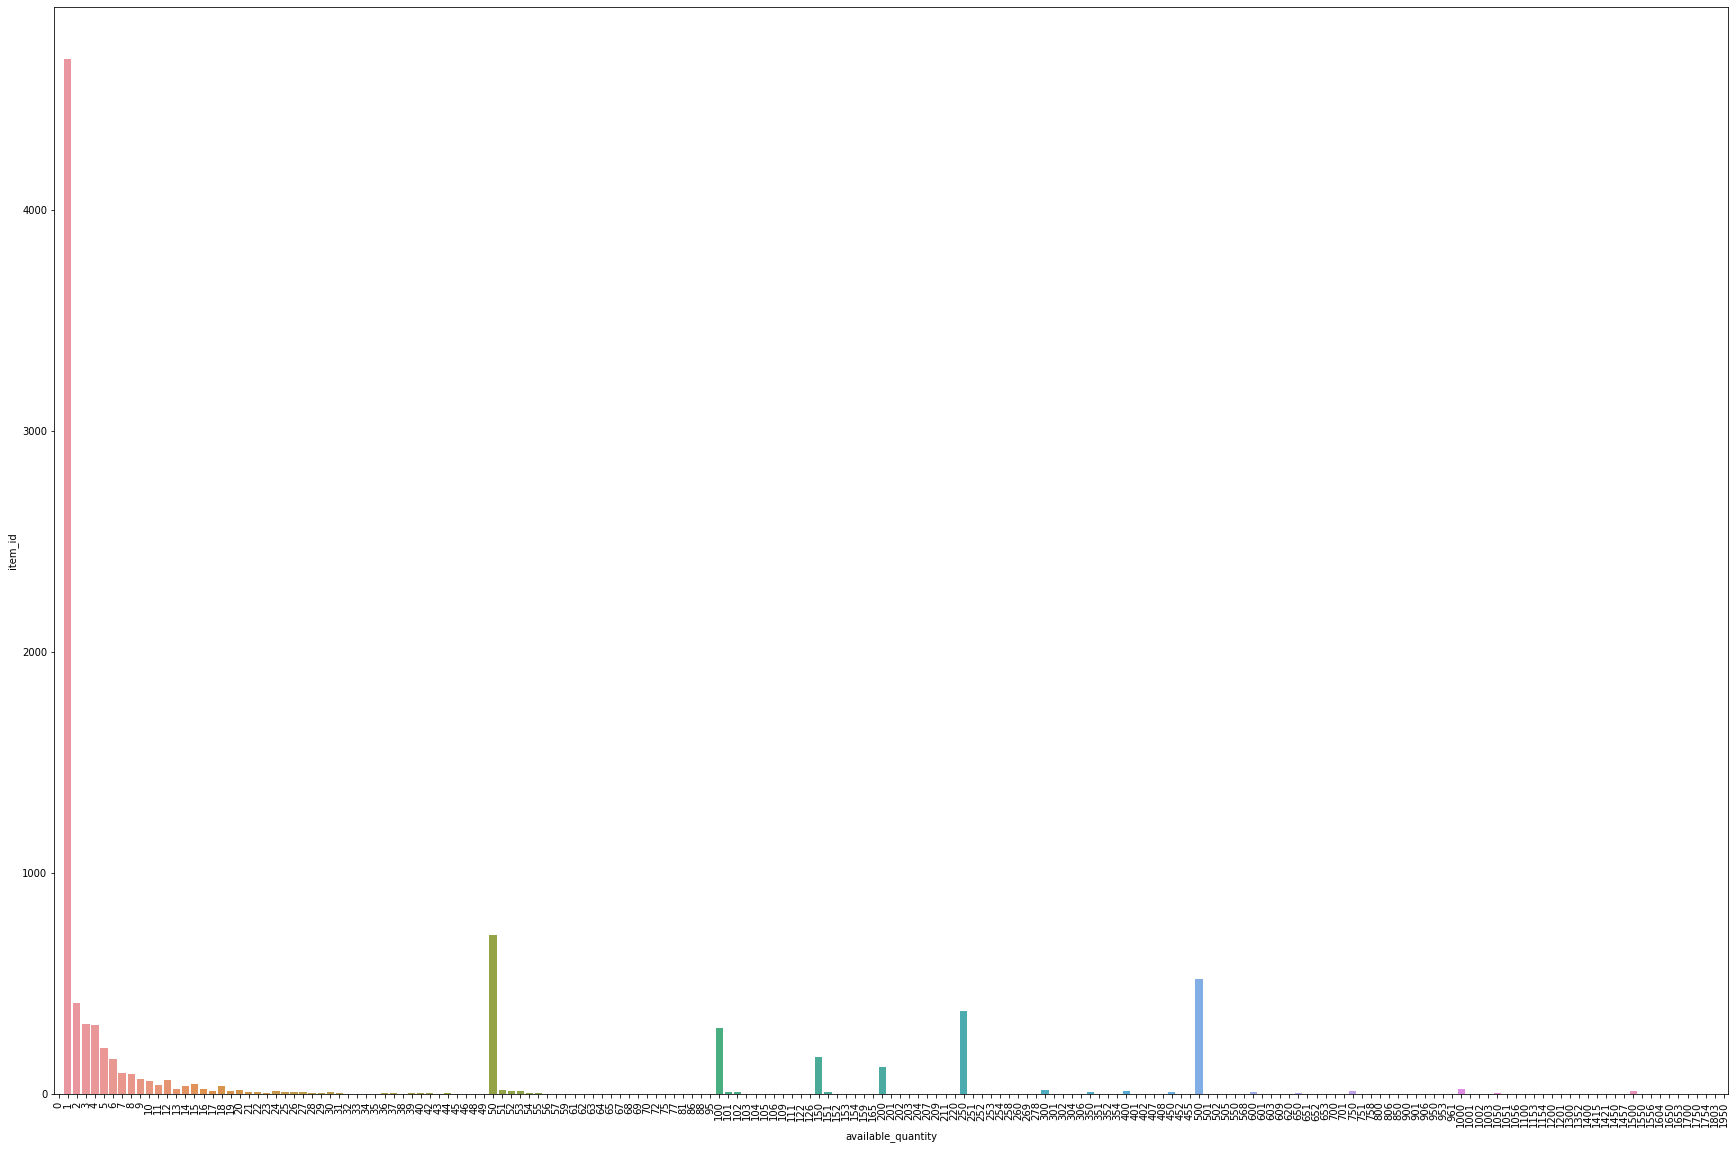

In [413]:
print(len(df_main[df_main['available_quantity'] < 2000]))
print(len(df_main[df_main['available_quantity'] >= 2000]))

dfq = df_main[df_main['available_quantity'] < 2000].groupby('available_quantity').count().reset_index()
plt.figure(figsize = (30,20))
ax = sns.barplot(data=dfq,y='item_id',x='available_quantity')
for item in ax.get_xticklabels():
    item.set_rotation(90)

9306
603


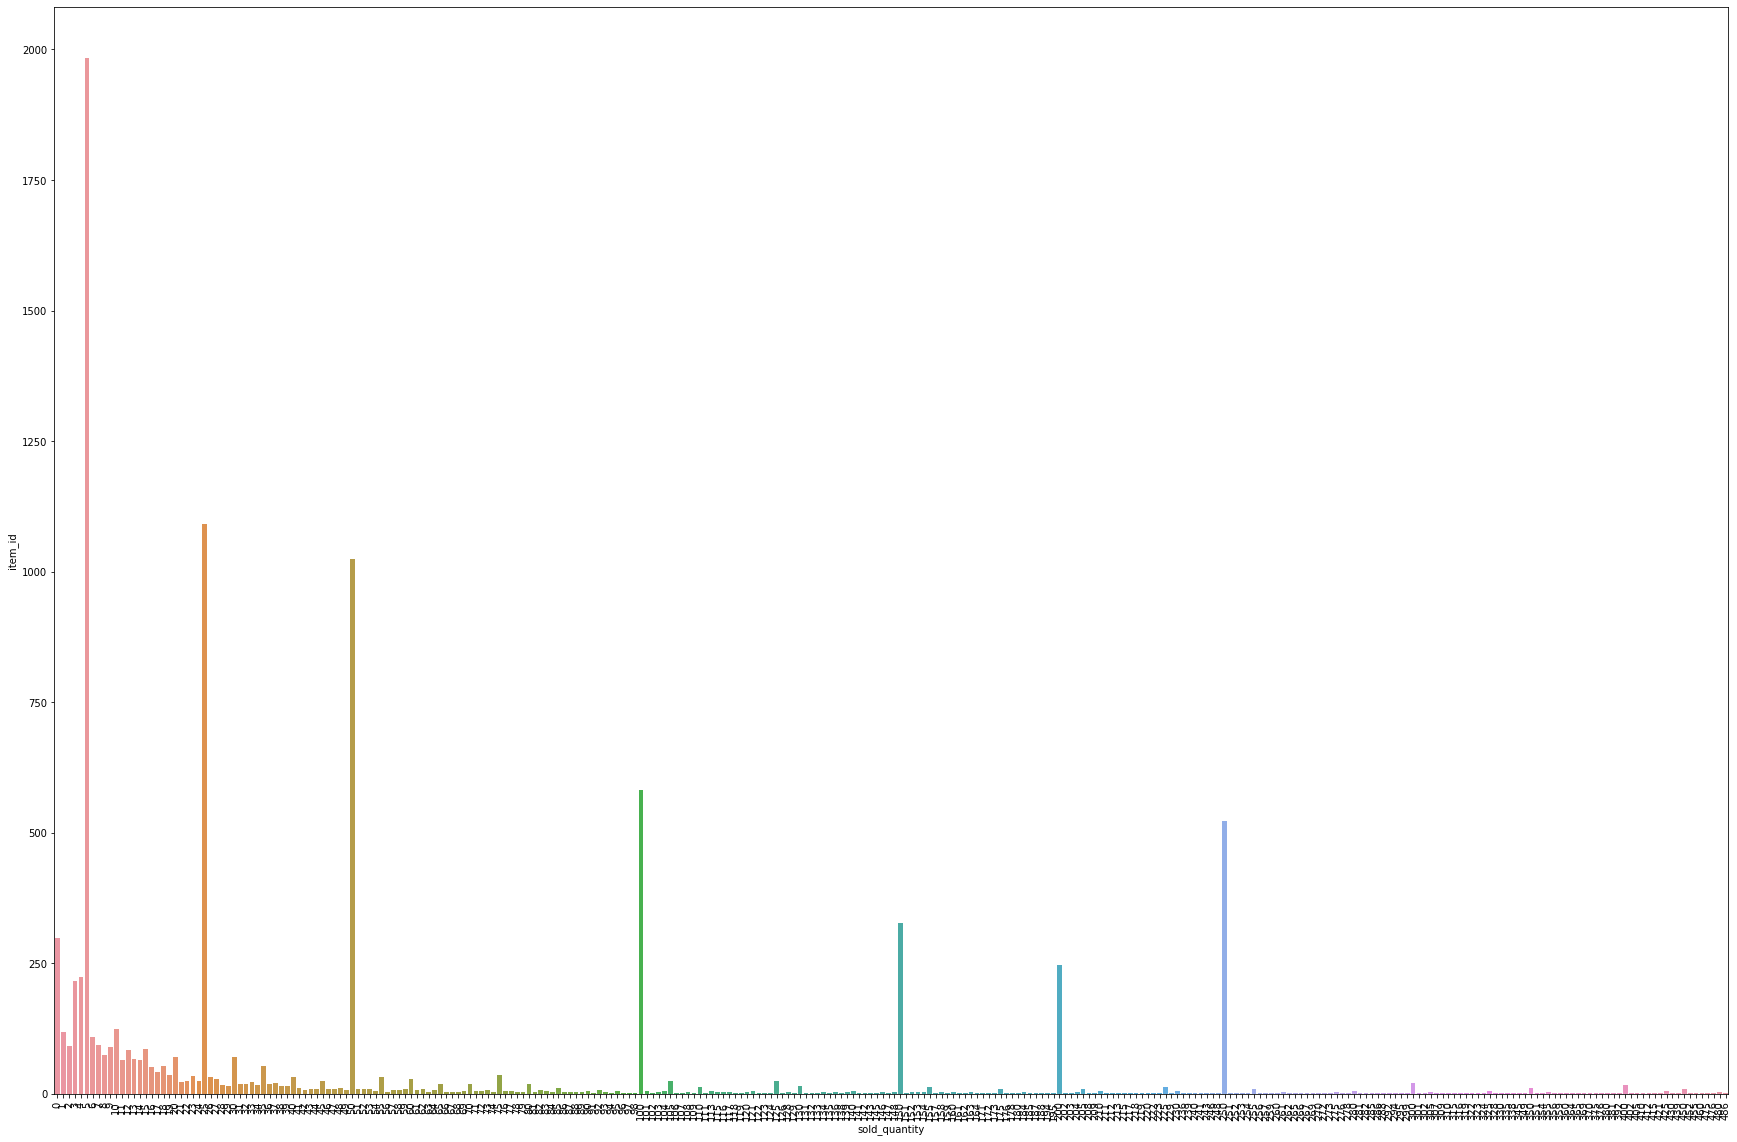

In [414]:
print(len(df_main[df_main['sold_quantity'] < 500]))
print(len(df_main[df_main['sold_quantity'] >= 500]))

dfq = df_main[df_main['sold_quantity'] < 500].groupby('sold_quantity').count().reset_index()
plt.figure(figsize = (30,20))
ax = sns.barplot(data=dfq,y='item_id',x='sold_quantity')
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [420]:
df_main[df_main['sold_quantity'] < 10]['available_quantity'].value_counts()
print('Existe una tendencia a que articulos con pocas ventas tengan poco stock disponible')

1       1976
50       233
500      157
250      142
2        137
        ... 
1050       1
609        1
600        1
408        1
1051       1
Name: available_quantity, Length: 73, dtype: int64

In [512]:
# Segun la documentacion de la api de ML los valores de sold_quantity y available cuantity son valores prederminados para rangos especificos
df_main.loc[((df_main['sold_quantity'] > 5) & (df_main['sold_quantity'] < 26)), 'sold_quantity'] = 5
df_main.loc[((df_main['sold_quantity'] >= 26) & (df_main['sold_quantity'] < 51)), 'sold_quantity'] = 25
df_main.loc[((df_main['sold_quantity'] >= 51) & (df_main['sold_quantity'] < 101)), 'sold_quantity'] = 50
df_main.loc[((df_main['sold_quantity'] >= 101) & (df_main['sold_quantity'] < 151)), 'sold_quantity'] = 100
df_main.loc[((df_main['sold_quantity'] >= 151) & (df_main['sold_quantity'] < 201)), 'sold_quantity'] = 150
df_main.loc[((df_main['sold_quantity'] >= 201) & (df_main['sold_quantity'] < 251)), 'sold_quantity'] = 200
df_main.loc[((df_main['sold_quantity'] >= 251) & (df_main['sold_quantity'] < 501)), 'sold_quantity'] = 250
df_main.loc[((df_main['sold_quantity'] >= 501) & (df_main['sold_quantity'] < 5001)), 'sold_quantity'] = 500
df_main.loc[((df_main['sold_quantity'] >= 5001) & (df_main['sold_quantity'] < 50001)), 'sold_quantity'] = 5000
df_main.loc[((df_main['sold_quantity'] >= 50001) & (df_main['sold_quantity'] < 500001)), 'sold_quantity'] = 50000

In [513]:
df_main['sold_quantity'].value_counts()

5       4286
25      1521
50       948
250      602
200      589
100      505
150      316
0        299
4        223
3        216
500      190
1        118
2         92
5000       4
Name: sold_quantity, dtype: int64

In [514]:
df_main.loc[((df_main['available_quantity'] >= 0) & (df_main['available_quantity'] < 51)), 'available_quantity'] = 1
df_main.loc[((df_main['available_quantity'] >= 51) & (df_main['available_quantity'] < 101)), 'available_quantity'] = 50
df_main.loc[((df_main['available_quantity'] >= 101) & (df_main['available_quantity'] < 151)), 'available_quantity'] = 100
df_main.loc[((df_main['available_quantity'] >= 151) & (df_main['available_quantity'] < 201)), 'available_quantity'] = 150
df_main.loc[((df_main['available_quantity'] >= 201) & (df_main['available_quantity'] < 251)), 'available_quantity'] = 200
df_main.loc[((df_main['available_quantity'] >= 251) & (df_main['available_quantity'] < 501)), 'available_quantity'] = 250
df_main.loc[((df_main['available_quantity'] >= 501) & (df_main['available_quantity'] < 5001)), 'available_quantity'] = 500
df_main.loc[((df_main['available_quantity'] >= 5001) & (df_main['available_quantity'] < 50001)), 'available_quantity'] = 5000
df_main.loc[((df_main['available_quantity'] >= 50001) & (df_main['available_quantity'] < 100000)), 'available_quantity'] = 50000

In [459]:
# Analizando la frecuencia de palabras en titulos de los productos
def word_counter(string_ls):
    dic = {}
    for string_full in string_ls:
        for string in re.findall(r'[a-zA-Z]{3,}',unidecode(string_full)):
            if string in dic.keys():
                dic[string] += 1
            else:
                dic[string] = 1
            
    return dic
title_count_dic = word_counter(list(df_main['title']))

print({k: v for k, v in sorted(title_count_dic.items(), key=lambda item: item[1], reverse=True)})

{'Para': 808, 'Con': 780, 'Mujer': 447, 'Led': 386, 'Kit': 340, 'Hombre': 329, 'Pack': 313, 'Set': 278, 'Original': 270, 'Juego': 266, 'Acero': 254, 'Luz': 211, 'Negro': 210, 'Premium': 196, 'Usb': 191, 'Algodon': 190, 'Colores': 184, 'Natura': 184, 'Funda': 165, 'Mesa': 162, 'Moto': 159, 'Talle': 157, 'Zapatillas': 151, 'Unidades': 151, 'Oferta': 143, 'Cuero': 143, 'Blanco': 141, 'Art': 139, 'Soporte': 137, 'Remera': 135, 'Sin': 134, 'Envio': 133, 'Cable': 133, 'Tela': 133, 'Calidad': 131, 'Crema': 130, 'Digital': 129, 'Cocina': 129, 'Bebe': 128, 'Color': 127, 'Combo': 124, 'Reloj': 123, 'Silicona': 120, 'Corta': 119, 'Talles': 117, 'Celular': 116, 'Caja': 116, 'Bluetooth': 115, 'Vidrio': 114, 'Madera': 114, 'Grande': 110, 'Mini': 110, 'Mts': 109, 'Agua': 109, 'Doble': 108, 'Profesional': 107, 'Gratis': 106, 'Casco': 106, 'Tipo': 104, 'Verano': 99, 'Manga': 99, 'Blanca': 97, 'Bano': 96, 'Auto': 96, 'Pro': 94, 'Full': 94, 'Ideal': 93, 'Samsung': 91, 'Protector': 90, 'Piezas': 88, 'Alto

In [468]:
df_main[df_main['title'].str.contains('Zapatilla')]['price'].describe()

count      214.000000
mean      3493.733084
std       2068.224177
min        231.570000
25%       2257.475000
50%       3000.200000
75%       4606.000000
max      16054.050000
Name: price, dtype: float64

In [470]:
zapatillas_count_dic = word_counter(list(df_main[df_main['title'].str.contains('Zapatilla')]['title']))
print({k: v for k, v in sorted(zapatillas_count_dic.items(), key=lambda item: item[1], reverse=True)})

{'Zapatillas': 151, 'Mujer': 78, 'Zapatilla': 64, 'Urbanas': 38, 'Plataforma': 36, 'Moda': 28, 'Hombre': 27, 'Urbana': 23, 'Zapato': 19, 'Sneaker': 19, 'Cuero': 18, 'Topper': 16, 'Olympikus': 16, 'Fila': 13, 'Running': 12, 'Dama': 12, 'Nuevos': 12, 'Modelos': 12, 'Deportiva': 11, 'Vacuno': 10, 'Deportivas': 10, 'Lona': 10, 'Savage': 10, 'Cordones': 9, 'Jaguar': 9, 'Hotsale': 9, 'Sneakers': 9, 'Del': 8, 'Nena': 7, 'Ninos': 7, 'Verano': 7, 'Con': 7, 'Atomik': 7, 'Originales': 6, 'Ninas': 6, 'Tela': 6, 'Pancha': 6, 'Acordonada': 6, 'Tenis': 5, 'Original': 5, 'Art': 5, 'Nuevo': 5, 'Stork': 5, 'Gratis': 5, 'Zapatos': 5, 'Blanca': 5, 'Alta': 5, 'Deportes': 5, 'Marvel': 5, 'Envios': 5, 'Cuotas': 4, 'Envio': 4, 'Cierre': 4, 'Elastizadas': 4, 'Tomas': 4, 'Lady': 4, 'Nautica': 4, 'Nauticas': 4, 'Botita': 4, 'Negro': 4, 'Livianas': 4, 'Calzados': 4, 'Fokker': 4, 'Cavatini': 4, 'Vestir': 4, 'Urbano': 4, 'Todo': 4, 'Pais': 4, 'Pata': 4, 'Sportif': 3, 'Unisex': 3, 'Negra': 3, 'Euro': 3, 'Jogger': 3,

In [473]:
df_main[(df_main['title'].str.contains('Zapatilla'))&(df_main['title'].str.contains('Hombre'))]['price'].describe()

count       29.000000
mean      3781.803793
std       2225.560834
min       1001.000000
25%       2325.000000
50%       3816.500000
75%       4417.060000
max      13860.500000
Name: price, dtype: float64

In [474]:
df_main[(df_main['title'].str.contains('Zapatilla'))&(df_main['title'].str.contains('Mujer'))]['price'].describe()

count      77.000000
mean     3015.896494
std      1416.887106
min      1033.060000
25%      2286.500000
50%      2540.000000
75%      3021.000000
max      8599.000000
Name: price, dtype: float64

In [469]:
df_main[df_main['title'].str.contains('Celular')]['price'].describe()

count      133.000000
mean      2144.687293
std       4048.270987
min         47.000000
25%        489.300000
50%        851.290000
75%       2375.000000
max      30899.000000
Name: price, dtype: float64

In [475]:
df_main['rating'].value_counts()

0.0    3895
5.0    2519
4.5    2490
4.0     701
3.5     136
3.0      95
2.5      25
1.0      24
2.0      21
1.5       3
Name: rating, dtype: int64

In [508]:
health_mean = float(df_main['health'].mode())
df_main['health'].fillna(health_mean,inplace=True)

In [509]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9909 entries, 0 to 10671
Data columns (total 65 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   item_id                                          9909 non-null   object 
 1   seller_id                                        9909 non-null   int64  
 2   available_quantity                               9909 non-null   int64  
 3   tags                                             9909 non-null   object 
 4   price                                            9909 non-null   float64
 5   original_price                                   9909 non-null   float64
 6   catalog_listing                                  9909 non-null   int64  
 7   listing_type_id                                  9909 non-null   object 
 8   shipping                                         9909 non-null   object 
 9   sold_quantity                

<h3> Analisis de la correlacion de los datos <\h3>

In [529]:
corr_matrix = df_main.corr().abs()

sold_cols_corr = corr_matrix[(corr_matrix['sold_quantity'] > 0.02) & (corr_matrix['sold_quantity'] < 0.95)]['sold_quantity'].keys()
print(corr_matrix[(corr_matrix['sold_quantity'] > 0.02) & (corr_matrix['sold_quantity'] < 0.95)]['sold_quantity'])

seller_id                                          0.046982
available_quantity                                 0.094992
price                                              0.053000
original_price                                     0.046198
catalog_listing                                    0.089297
pictures                                           0.138768
rating                                             0.256467
review_count                                       0.020999
user_type                                          0.044461
points                                             0.024502
seller_reputation_power_seller_status              0.097872
seller_reputation_transactions_ratings_negative    0.030096
seller_reputation_transactions_ratings_positive    0.027378
tags_deal_of_the_day                               0.101999
tags_good_quality_thumbnail                        0.088943
tags_dragged_bids_and_visits                       0.104750
seller_tags_brand                       

In [ ]:
plt.figure(figsize = (40,30))
sns.heatmap(df_main.filter(sold_cols_corr),annot=True)

<h3> Prueba inicial del algoritmo con los features seleccionados <h3>

In [520]:
X = df_main.filter(sold_cols_corr)
Y = df_main["sold_quantity"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [518]:
# MODELO CON FILTRO DE COLUMNAS POR IMPORTANCIA
X = df_main.filter(ndrop_cols)
Y = df_main["sold_quantity"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [528]:
rf = RandomForestRegressor(n_estimators = 50,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, Y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, Y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, Y_test)))

R^2 Training Score: 0.92 
OOB Score: 0.35 
R^2 Validation Score: 0.46


In [523]:
from sklearn import metrics
mae = []
mse = []
rmse = []
for x in range(1,201):
    rf = RandomForestRegressor(n_estimators = x,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
    rf.fit(X_train, Y_train)
    
    mae.append(metrics.mean_absolute_error(Y_test, rf.predict(X_test)))
    mse.append(metrics.mean_squared_error(Y_test, rf.predict(X_test)))
    rmse.append(np.sqrt(metrics.mean_squared_error(Y_test, rf.predict(X_test))))

<AxesSubplot:>

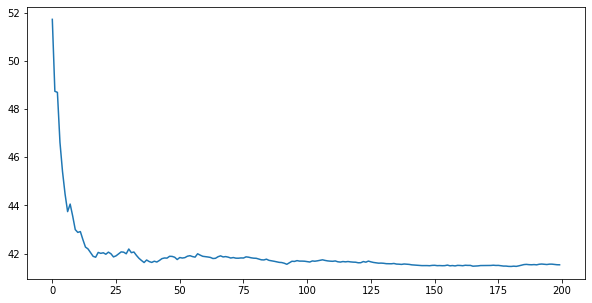

In [530]:
plt.figure(figsize = (10,5))
sns.lineplot(data=mae)

<AxesSubplot:>

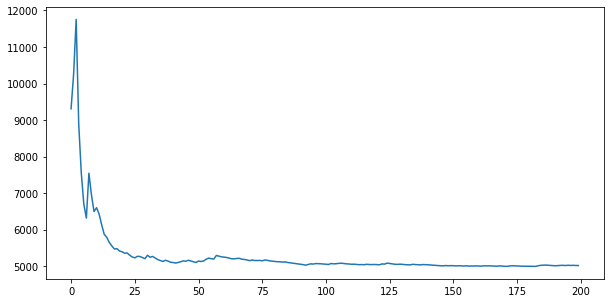

In [525]:
plt.figure(figsize = (10,5))
sns.lineplot(data=mse)

<AxesSubplot:>

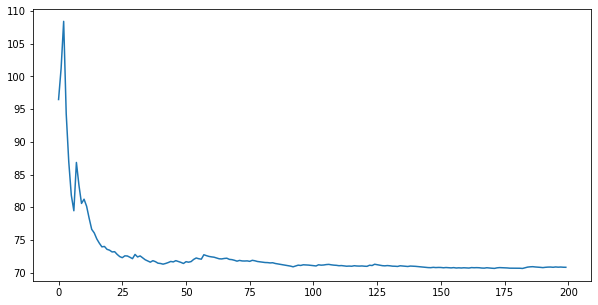

In [526]:
plt.figure(figsize = (10,5))
sns.lineplot(data=rmse)

In [ ]:
# Pareceria que en 50 estimadores se alcanza el minimo error del modelo

<h3> Guardado del modelo </h3>

In [522]:
import pickle
pickle.dump(rf, open('ml_descuentos_RandFore_alto.sav', 'wb'))

<h3> Importancia de los features <\h3>

In [327]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

In [344]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, Y_train, r2)

In [345]:
perm_imp_rfpimp

,Importance
Feature,
review_count,0.711215
available_quantity,0.515458
rating,0.467843
pictures,0.342978
original_price,0.131658
price,0.126061
tags_dragged_bids_and_visits,0.085209
seller_reputation_transactions_completed,0.078918
seller_id,0.074984


In [347]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, Y_train)

def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
    'feature_importance': importances})\
    .sort_values('feature_importance', ascending = False)\
    .reset_index(drop = True)
    return df
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)

perm_imp_eli5

In [354]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [355]:
df_drop_imp = drop_col_feat_imp(rf, X_train, Y_train)

In [363]:
ndrop_cols = list(df_drop_imp[df_drop_imp['feature_importance'] > 0]['feature'])

<AxesSubplot:>

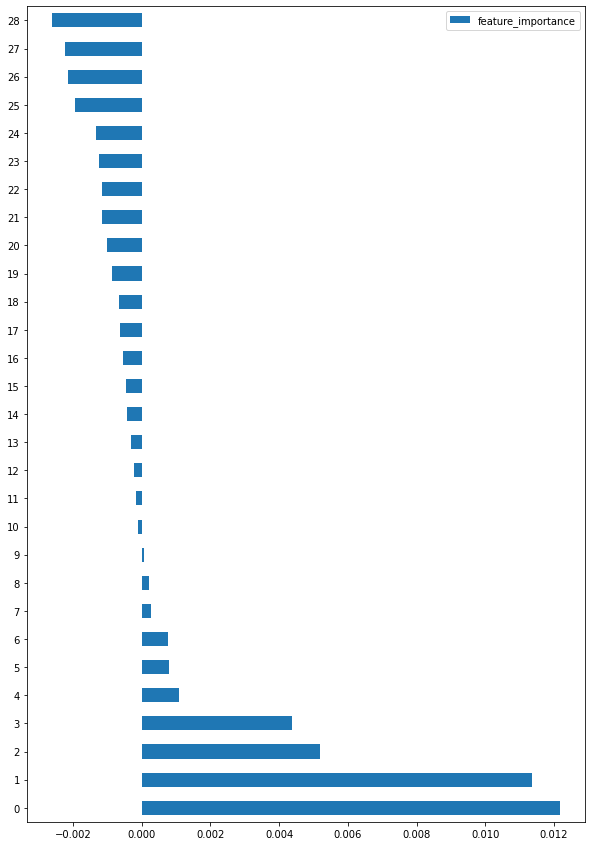

In [359]:
df_drop_imp.plot(kind='barh',figsize=(10,15))

<h3> Prueba con un algoritmo de clasificador XGBoost y comparacion con Random Forest <\3>

In [435]:
from xgboost import XGBClassifier
xgbcl = XGBClassifier()

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report

rfcl = RandomForestClassifier()

In [531]:
xgbcl.fit(X_train,Y_train)
rfcl.fit(X_train,Y_train)

y_rfcl = rfcl.predict(X_test)
y_xgbcl = xgbcl.predict(X_test)

In [532]:
print("Random Forest Accuracy: ", accuracy_score(y_rfcl,Y_test))
print("XGBoost Accuracy: ", accuracy_score(y_xgbcl,Y_test))

Random Forest Accuracy:  0.48234106962663975
XGBoost Accuracy:  0.47780020181634714
